In [1]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [2]:
## Adding a button to hide the Python source code
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10791: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.renebreton.org">Prof. Rene Breton</a> - Twitter <a href="https://twitter.com/BretonRene">@BretonRene</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Dr. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

<div class="queue">
    Lecture 11 - 00:00
</div>

## 6.1 Errors

Measurement typically represented using central value (i.e. mean), and uncertainty (i.e. standard deviation). Simplifying representation of actual probability distribution. Often sufficient (i.e. CLT -> Gaussian).

### 6.1.1 Types of errors

There are two types of errors typically encountered in data science.

#### Statistical errors

Arise from 'random fluctuation' in the experiment. CLT implies that repeated measurements would improve how well the real value can be known.

An example of this would be the oscillation period measured in the pendulum experiment

#### Systematic errors

Sometimes statistical bias or non-zero mean errors. Will not improve even if more data are collected. Typically one of three sources: 1) (calibration) offset, 2) (quantity) scaling, 3) drift.

An example would be the accuracy to which you can measure the length of the string for the pendulum experiement.

```Did you know... that we know the mass of planets in our Solar System much better in units of G times Solar masses than in kg? Measurements of their orbits are extremely accurate, however the exact mass of the Sun is rather 'uncertain' due to uncertainties in the gravitational constant.```

<div class="example">Example: Errors in my research</div>

<img src="images/error_types.pdf" width=75% >

*The above shows the optical light curves of the small companion of a pulsar in a binary system. We can measure the fluxes very well, and more data or a large telescope would increase the quality of the light curves even further. This is related to the statistical uncertainty in the data. However, we suffer limitations from two main systematic uncertainties. First, the numerical simulations of stellar atmospheres are not perfect and so leave uncertainties in the light curves models. Second, it is very difficult to measure the absolute flux scale perfectly which means that while the light curve is very accurate within a filter, the entire set of data in each filter could suffer a small systematic vertical offset.*

<div class="queue">
    Lecture 11 - 00:10
</div>

### 6.1.2 Propagation of errors

#### One variable case

Consider $f = ax + b$. Represent uncertainty on function using variance as a measure of the spread. In which case:

\begin{eqnarray}
  V(f) &=& \langle f^2 \rangle - \langle f \rangle^2 \\
       &=& \langle (ax + b)^2 \rangle - \langle ax + b \rangle^2 \\
       &=& a^2 \langle x^2 \rangle + 2ab \langle x \rangle + b^2 - a^2 \langle x \rangle^2 - 2ab \langle x \rangle - b^2 \\
       &=& a^2 (\langle x^2 \rangle - \langle x \rangle^2) \\
       &=& a^2 V(x) \,.
\end{eqnarray}

Equivalent to $\sigma_f = \lvert a \rvert \sigma_x$.

For arbitrary function of one variable, Taylor expansion yields:

\begin{equation}
  f(x) \approx f(x_0) + (x-x_0) \left( \frac{\partial f}{\partial x} \right)_{x=x_0} \,.
\end{equation}

The variance is:

\begin{equation}
  V(f) \approx \left( \frac{\partial f}{\partial x} \right)^2 V(x) \,.
\end{equation}

#### General multiple variables case

For multiple variables, can use the same development:

\begin{equation}
  V(f) \approx \left( \frac{\partial f}{\partial x} \right)^2 V(x) + \left( \frac{\partial f}{\partial y} \right)^2 V(y) + \dots + 2 \left( \frac{\partial f}{\partial x} \right) \left( \frac{\partial f}{\partial y} \right) \operatorname{cov} (x,y) + \dots
\end{equation}

Special case of uncorrelated variables, we get simple law of propagation of errors.

<div class="queue">
    Lecture 11 - 00:25
</div>

## 6.2 Monte Carlo

Monte Carlo methods: general class of computational techniques that rely on random sampling to solve problems numerically. Three types of 'typical' problems:

1. Numerical integrations
2. Sampling from arbitrary probability distribution
3. Optimization

<img src="images/monte_carlo.jpg" width=80%>

### 6.2.1 Uniformly distributed random numbers

Monte Carlo methods are based on drawing samples from a stochastic process. How to generate sequence of numbers from specific distributions? 'Easiest' is sample uniformly distributed random numbers. Computers are deterministic so can only produce pseudo-random numbers. Can pass tests for randomness but will repeat over long intervals.

**Linear congruential generator (LCG)** is one of the most common algorigthm. Starts with initial integer value $n_0$ called **seed**, and generate series iteratively using three parameters, the **multiplier** $a$, the **increment** $c$ and the **modulus** $m$ according to:

\begin{equation}
  n_{i} = (a n_{i-1} + c) \operatorname{mod} m \,,
\end{equation}

where $\operatorname{mod}$ is the modulo operator. Produces set of integer in the range $[0,m-1[$. For uniformly distributed value in the range $[0,1[$:

\begin{equation}
  r_{i} = \frac{n_i}{m} \,.
\end{equation}

Always reproduces same sequence for given seed value, repeat on period $P \leq m$. Any choice of large $m$ is fine, but prime numbers produce well-behaved sequences.

Special case $c=0$ is known as **multiplicative congruential generator (MCG)**:

\begin{equation}
  n_{i} = (a n_{i-1}) \operatorname{mod} m \,,
\end{equation}

<div class="example">Example 1</div>

Drawing random samples using the MCG. Here we use the following parameters:

| seed | a | m  |
| ---- | - | -- |
| 5    | 3 | 42 |

In [3]:
## We will try the multiplicative conguential generator method

## These are the initial parameters
seed = 5
a = 3
m = 42

n = [seed]
## We calculate 6 random numbers after the seed
for i in range(7):
    print('i: {}'.format(i))
    print('  n_i: {}'.format(n[i]))
    an = a*n[i]
    n.append(an%m)
    print('  a*n mod m: {}*{} mod {} = {}'.format(n[-2],a,m,n[-1]))

i: 0
  n_i: 5
  a*n mod m: 5*3 mod 42 = 15
i: 1
  n_i: 15
  a*n mod m: 15*3 mod 42 = 3
i: 2
  n_i: 3
  a*n mod m: 3*3 mod 42 = 9
i: 3
  n_i: 9
  a*n mod m: 9*3 mod 42 = 27
i: 4
  n_i: 27
  a*n mod m: 27*3 mod 42 = 39
i: 5
  n_i: 39
  a*n mod m: 39*3 mod 42 = 33
i: 6
  n_i: 33
  a*n mod m: 33*3 mod 42 = 15


<div class="queue">
    Lecture 11 - 00:40
</div>

### 6.2.2 Numerical integration

Many integrals without analytical solutions. Canonical example is the Gaussian function:

\begin{equation}
  I = \int_a^b e^{-\lvert \alpha \rvert x^2} dx
\end{equation}

Only an analytic solution for limits $(-\infty,\infty)$.

#### Deterministic integration methods

Consider:

\begin{equation}
  I = \int_a^b f(x) dx
\end{equation}

One way to integrate is using the sum of $n$ small discrete intervals:

\begin{equation}
  I \approx \frac{b-a}{n} \sum_{i=1}^{n} f(x_i)
\end{equation}

with

\begin{equation}
  x_i = a + \left( i-\frac{1}{2} \right)\frac{(b-a)}{n}
\end{equation}

Technique known as **trapezoid method**. Convergence to exact solution as $\mathcal{O}(n^{-2})$, where $n$ is number of intervals. In $d$ dimensions, accuracy scales as $\mathcal{O}(n^{-\frac{2}{d}})$. More efficient integration techniques exist. Simpson's Rule is $\mathcal{O}(n^{-4})$ or slightly better.

Why using MCMC? The law of large numbers tells us that:

\begin{equation}
  P \left( \lim_{n\to\infty} \bar{X}_n = \mu \right) = 1 \,.
\end{equation}

For large number of samples, sample mean $\bar{X}_n$ converges to true mean $\mu$. Given the CLT the variance of a Monte Carlo integration should be:

\begin{equation}
  \operatorname{V}(\bar{X}_n - \mu) = \frac{\sigma^2}{n} \,.
\end{equation}

Monte Carlo integration will scale as $\mathcal{O}(n^{\frac{-1}{2}})$, independent of the number of dimensions $d$.

<div class="queue">
    Lecture 12 - 00:00
</div>

#### 'Crude' Monte Carlo integration

Procedure to integrate $\int_a^b f(x) dx$, using a crude Monte Carlo technique.

- Generate $n$ random numbers $r_i$ from a uniform distribution $U(0,1)$.
- Evaluate the integral according to:

  \begin{equation}
    \frac{b-a}{n} \sum_{i=1}^{n} f(x_i)
  \end{equation}
  with $x_i = a + r_i(b-a)$.

#### Rejection sampling integration

Better alternative is acceptance-rejection method developed by von Neumann. Relies on enclosing PDF within a box with range made of integration limits (i.e. $a$ to $b$) and height $f_{\rm max}$ close to PDF maximum. Generate random points within this box, then calculate the fraction that falls below the function and multiply by the area of the box.

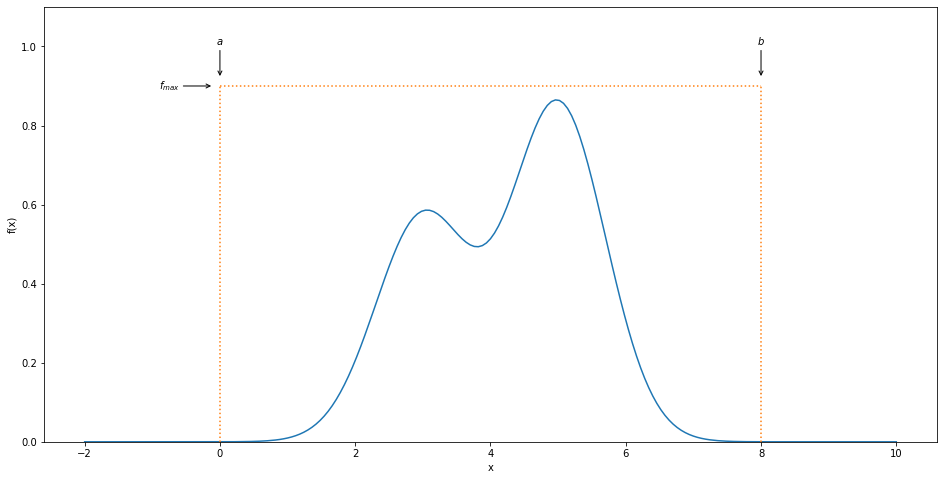

In [4]:
## Generating the subplot
fig, ax = plt.subplots(1, 1, figsize=(16,8))

x = np.linspace(-2,10,201)
y = scipy.stats.norm.pdf(x, loc=3, scale=0.7) + 1.5*scipy.stats.norm.pdf(x, loc=5, scale=0.7)

ax.plot(x, y)
ax.plot([0,0],[0,0.9],'C1:')
ax.plot([8,8],[0,0.9],'C1:')
ax.plot([0,8],[0.9,0.9],'C1:')

ax.annotate('$f_{max}$', xy=(-0.1, 0.9), xycoords='data',
            xytext=(-0.6, 0.9), textcoords='data', va='center', ha='right',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
ax.annotate('$a$', xy=(0.0, 0.92), xycoords='data',
            xytext=(0.0, 1.0), textcoords='data', va='bottom', ha='center',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
ax.annotate('$b$', xy=(8, 0.92), xycoords='data',
            xytext=(8, 1.0), textcoords='data', va='bottom', ha='center',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
ax.set_ylim(0,1.1)
ax.set_xlabel('x')
_ = ax.set_ylabel('f(x)')

Here is the procedure to integrate a function $f(x)$ using this method:

- Generate a random number $x$, uniformally distributed between $a$ and $b$, i.e. $x = a + r_1(b-a)$ with $r_1 \sim U(0,1)$.
- Generate a second random number $u_i$.
- If $u < f(x)/f_{\rm max}$, then accept x.

After $n$ iterations the value of the integral can by computed directly:

\begin{equation}
  \int_a^b f(x) dx \approx \frac{n_{\rm accepted}}{n} (b-a) f_{\rm max} \,.
\end{equation}

Other advantage: accepted samples will be distributed according to $f(x)$. They can be used for other purposes (e.g. mean, standard deviation, sampling).

Limited efficiency (determined by ratio $\frac{n_{\rm accepted}}{n}$). Problematic case: function with high, narrow peak but a heavy tail.

<div class="queue">
    Lecture 12 - 00:10
</div>

<div class="example">Example 1: Calculating Pi</div>

We know that the area of a circle is given by $A = \pi r^2$, where $r$ is the radius of the circle. Calculating area of a circle and dividing by the square of the radius yields $\pi$.

Consider circle of unit radius centered at (0,0). Calculate area of a quarter circle located in first quadrant yields $\pi/4$. Therefore consider the integral $I = \pi/4 = \int_0^1 \sqrt{1 - x^2} dx$ using above technique with box in range $\[0, 1\]$ for both $x$ and $y$.

Can also think in terms of geometry: generate $(x,y)$ pairs of uniform random numbers in the range [0,1], calculate the radius using $r = \sqrt{x^2 + y^2}$ and determine whether the pair is located at $r \leq 1$.

We shall use the second technique below.

Calculating the value of pi using a n=1000 points Monte Carlo
  Measured value: 3.12800
  Difference (measured-expected): -0.01359
  Fractional difference: -0.00433


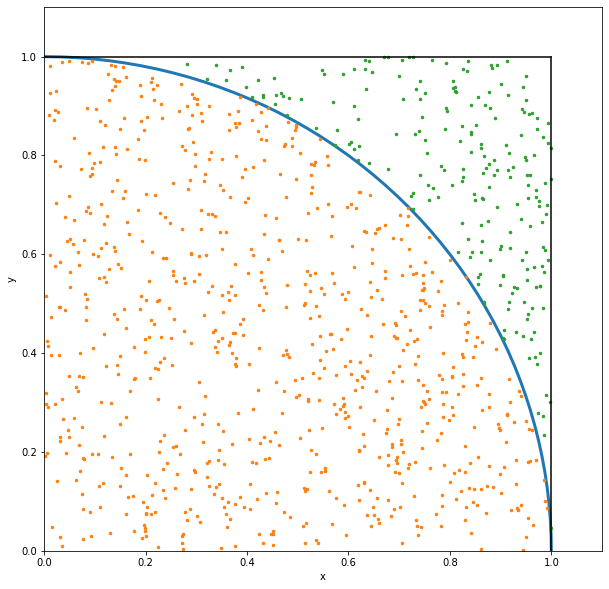

In [5]:
##### Actual Monte Carlo calculation

## Defining pairs of uniform random numbers, here 1000 of them
n = 1000
x = np.random.rand(n)
y = np.random.rand(n)

## Calculating the radius
r = np.sqrt(x**2 + y**2)

## Calculating the number that are within the unit wedge
inside = r <= 1
ratio = np.sum(inside) / float(n)

## Calculating the value of pi, which is 4*I. Bear in mind that f_max*(b-a) is 1.
pi_measured = ratio * 4

print('Calculating the value of pi using a n={} points Monte Carlo'.format(n))
print('  Measured value: {:.5f}'.format(pi_measured))
print('  Difference (measured-expected): {:.5f}'.format(pi_measured-np.pi))
print('  Fractional difference: {:.5f}'.format(pi_measured/np.pi-1))


##### Plotting the Monte Carlo data

## Generating the subplot
fig, ax = plt.subplots(1, 1, figsize=(10,10))

## Creating the circle in polar coordinates
theta = np.linspace(0,np.pi/2)
ax.plot(np.cos(theta), np.sin(theta), lw=3)

## Plotting the random points using two colours (for inside and outside)
ax.plot(x[inside], y[inside], '.', ms=5)
ax.plot(x[~inside], y[~inside], '.', ms=5)

## Boundaries of enclosing square
ax.plot([0,1],[1,1], 'k')
ax.plot([1,1],[0,1], 'k')

ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xlabel('x')
_ = ax.set_ylabel('y')

#### Advantages of using Monte Carlo Integration

- Simplicity
- Unbiased and consistent
- Parallel nature

#### Disadvantages of using Monte Carlo Integration

- Slow rate of convergence
- Difficult to evaluate the uncertainty of the approximation

<div class="queue">
    Lecture 12 - 00:20
</div>

### 6.2.3 Sampling from an arbitrary probability distribution

Generating samples from arbitrary probability distribution is more difficult.

There are three standard methods to produce such arbitrary probability distribution $f(x)$.

#### Method 1: Weighted sampling

Generate a uniform random variable $x = a + r(b-a)$ with $r \sim U(0,1)$, and weight each event by the factor $w = f(x)$. So each event is characterised by $x$ and $w$.

Extremely simple but restricted usefulness. Can be used to calculate moments of a function.

#### Method 2: Rejection sampling

This is the method described earlier in the integration subsection.

#### Method 3: Inverse transform sampling

The probability integral transform (see Cowan, S3.2 for the proof) states that that if $f(x)$ is a continuous random variable with cumulative distribution function $F(x)$, then the random variable $r=F(x)$ has a uniform distribution on $U(0,1)$. The consequence is that if we can determine the cumulative distribution function of a probability distribution, its inverse will be distributed like that distribution $f(x)$.

For instance, imagine the exponential function $f(x) = \frac{1}{\tau}e^{-x/\tau}$. The cummulative distribution function is:

\begin{eqnarray}
  F(x) &=& \int_0^{x(r)} \frac{1}{\tau}e^{-x^\prime/\tau} dx^\prime &=& r \\
       &=& 1 - e^{-x(r)/\tau} &=& r \,,
\end{eqnarray}

with $r \sim U(0,1)$. If we invert the function we find that:

\begin{equation}
  x(r) = -\tau \log (1-r) \,.
\end{equation}

Hence, by sampling $r$ from a uniform function and substituting into the above equation we can generate samples that follow the distribution $f(x)$.

Most optimal way of generating samples from arbitrary PDF. Requires: 1) calculating CDF and 2) inverting it. Not always possible analytically.

<div class="queue">
    Lecture 12 - 00:40
</div>

### 6.2.4 Optimization

Optimization cover a very wide range of problems. The goal is typically to simulate multiple alternate realisations of a situation and determine which one of them provides the most optimal solution, typically by analysing the value of a certain cost function.

There are multiple examples of it:

- Finding the best fit parameters of a model through a least square fit
- Finding the minimum of a function
- Reproducing the propagation of a particle subjected to scattering (i.e. ray tracing)
- Optimizing the itinerary of a [travelling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem)


<div class="example">Example 1: Travelling salesman</div>

The travelling salesman problem is a well known problem in which one asks the question "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?". In computational complexity theory this is known as an NP-hard problem (i.e. non-deterministic polynomial-time problem), which forms the basis of the most difficult computational problems to solve. Several optimiszation problems are very similar to the travelling salesman problem, hence why it became so famous since the 1930s.

While there are more efficient algorithms to tackle specific cases of the travelling salesman problem, the brute force Monte Carlo approach consists of drawing an itinerary at random, calculating the total travelled distance, and repeat the process a number of times while keeping track of the best solution. The figure below illustrates the process.

<img src="images/Bruteforce.gif" width=90%>

(Source: [Saurabh.harsh](https://commons.wikimedia.org/wiki/User:Saurabh.harsh), [Bruteforce](https://commons.wikimedia.org/wiki/File:Bruteforce.gif), [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/legalcode))

<div class="example">Example 1: Ray tracing</div>

For ray tracing, the path of light rays is followed from the emitting source(s) and effects such as reflections on surfaces are taken into account through the propagation. A 'camera' is located at a certain position and registers the light coming to it.

<img src="images/1280px-Glasses_800_edit.png" width=80%>

(Source: [Ray tracing](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)))

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>